<a href="https://colab.research.google.com/github/JoeG96/AICT/blob/main/GradCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/yiskw713/SmoothGradCAMplusplus.git

fatal: destination path 'SmoothGradCAMplusplus' already exists and is not an empty directory.


In [ ]:
%cd /content/SmoothGradCAMplusplus/

/content/SmoothGradCAMplusplus


In [ ]:
import cam

In [ ]:
%matplotlib inline

import numpy as np
import skimage.transform
import torch
import torch.nn as nn
import torch.nn. functional as F

from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torchvision.utils import save_image

from cam import CAM, GradCAM, GradCAMpp, SmoothGradCAMpp
from utils.visualize import visualize, reverse_normalize
from utils.imagenet_labels import label2idx, idx2label

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
!unzip '/content/gdrive/MyDrive/Datasets/FlagDataset.zip' > /dev/null

replace Flags/denflags/denflag (1).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Flags/denflags/denflag (10).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders

In [ ]:
splitfolders.ratio("/content/SmoothGradCAMplusplus/Flags", output='splitdataset',
                   seed = 1337, ratio=(.70,.15,.15), group_prefix=None, move=False)

Copying files: 1200 files [00:00, 4530.88 files/s]


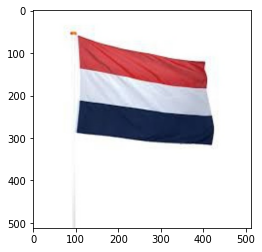

In [ ]:
image = Image.open('/content/SmoothGradCAMplusplus/Flags/nedflags/nedflag (11).jpg')
imshow(image)

In [ ]:
# preprocessing. mean and std from ImageNet
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

preprocess = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

In [ ]:
# convert image to tensor
tensor = preprocess(image)

# reshape 4D tensor (N, C, H, W)
tensor = tensor.unsqueeze(0)

In [ ]:
# Load previously trained model

# create a new model with ResNet50 architecture
myModel = models.resnet50(pretrained=True)
# get the number of inputs for the final layer (fc) of the network
num_ftrs = myModel.fc.in_features
# replace the final layer so that the output is 10 classes
myModel.fc = nn.Linear(num_ftrs, 10)
# load previously trained model
myModel.load_state_dict(torch.load('/content/gdrive/MyDrive/resnet50_model09122022.pt'))

myModel.eval()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# the target layer you want to visualize
target_layer = myModel.layer4[1].conv3

# wrapper for class activation mapping. Choose one of the following.
wrapped_model_CAM = CAM(myModel, target_layer)
#wrapped_model_GradCAM = GradCAM(myModel, target_layer)
#wrapped_model_GradCAMpp = GradCAMpp(myModel, target_layer)
#wrapped_model_SmoothGradCAMpp = SmoothGradCAMpp(myModel, target_layer, n_samples=25, stdev_spread=0.15)

In [ ]:
cam_CAM, idx_CAM = wrapped_model_CAM(tensor)
#cam_GradCAM, idx_GradCAM = wrapped_model_GradCAM(tensor)
#cam_GradCAMpp, idx_GradCAMpp = wrapped_model_GradCAMpp(tensor)
#cam_SmoothGradCAMpp, idx_SmoothGradCAMpp = wrapped_model_SmoothGradCAMpp(tensor)

predicted class ids 6	 probability 0.6702067255973816


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1113: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


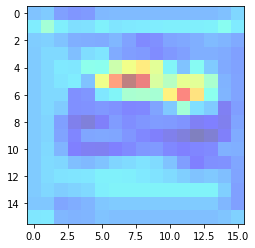

In [ ]:
# visualize only cam
imshow(cam_CAM.squeeze().numpy(), alpha=0.5, cmap='jet')
#imshow(cam_GradCAM.squeeze().numpy(), alpha=0.5, cmap='jet')
#imshow(cam_GradCAMpp.squeeze().numpy(), alpha=0.5, cmap='jet')
#imshow(cam_SmoothGradCAMpp.squeeze().numpy(), alpha=0.5, cmap='jet')

In [ ]:
# reverse normalization for display
img = reverse_normalize(tensor)

In [ ]:
heatmap_CAM = visualize(img, cam_CAM)
#heatmap_GradCAM = visualize(img, cam_GradCAM)
#heatmap_GradCAMpp = visualize(img, cam_GradCAMpp)
#heatmap_SmoothGradCAMpp = visualize(img, cam_SmoothGradCAMpp)

In [ ]:
# save image
#save_image(heatmap_CAM, './sample/CAM.png')
#save_image(heatmap_GradCAM, './sample/GradCAM.png')
#save_image(heatmap_GradCAMpp, './sample/GradCAMpp.png')
#save_image(heatmap_SmoothGradCAMpp, './sample/SmoothGradCAMpp.png')

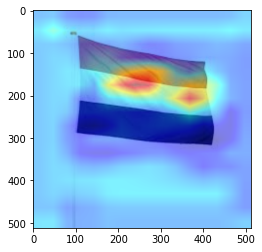

In [ ]:
# or visualize on Jupyter
hm_CAM = (heatmap_CAM.squeeze().numpy().transpose(1, 2, 0))
imshow(hm_CAM)
#hm_GradCAM = (heatmap_GradCAM.squeeze().numpy().transpose(1, 2, 0))
#imshow(hm_GradCAM)
#hm_GradCAMpp = (heatmap_GradCAMpp.squeeze().numpy().transpose(1, 2, 0))
#imshow(hm_GradCAMpp)
#hm_SmoothGradCAMpp = (heatmap_SmoothGradCAMpp.squeeze().numpy().transpose(1, 2, 0))
#imshow(hm_SmoothGradCAMpp)